<a href="https://colab.research.google.com/github/brndcarvalho/nba_modelo/blob/main/NBA_Modelin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sklearn import tree
import matplotlib.pyplot as plt
!pip install pyspark

Modelo Aproveitamento

In [9]:
###Lendo a base de dados
df = pd.read_csv("/content/nbaRegular.csv", encoding='latin-1', sep = ';')
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,PF-C,24,TOT,74,18,21.9,3.2,6.3,...,0.616,2.6,4.0,6.6,1.3,0.6,0.9,1.1,1.9,7.6
1,1,Precious Achiuwa,C,24,TOR,25,0,17.5,3.1,6.8,...,0.571,2.0,3.4,5.4,1.8,0.6,0.5,1.2,1.6,7.7
2,1,Precious Achiuwa,PF,24,NYK,49,18,24.2,3.2,6.1,...,0.643,2.9,4.3,7.2,1.1,0.6,1.1,1.1,2.1,7.6
3,2,Bam Adebayo,C,26,MIA,71,71,34.0,7.5,14.3,...,0.755,2.2,8.1,10.4,3.9,1.1,0.9,2.3,2.2,19.3
4,3,Ochai Agbaji,SG,23,TOT,78,28,21.0,2.3,5.6,...,0.661,0.9,1.8,2.8,1.1,0.6,0.6,0.8,1.5,5.8


In [10]:
create_spark_session = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

In [11]:
# convertendo para spark dataframe
sparkDF=create_spark_session.createDataFrame(df)
sparkDF.printSchema()
sparkDF.show()


root
 |-- Rk: long (nullable = true)
 |-- Player: string (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Tm: string (nullable = true)
 |-- G: long (nullable = true)
 |-- GS: long (nullable = true)
 |-- MP: double (nullable = true)
 |-- FG: double (nullable = true)
 |-- FGA: double (nullable = true)
 |-- FG%: double (nullable = true)
 |-- 3P: double (nullable = true)
 |-- 3PA: double (nullable = true)
 |-- 3P%: double (nullable = true)
 |-- 2P: double (nullable = true)
 |-- 2PA: double (nullable = true)
 |-- 2P%: double (nullable = true)
 |-- eFG%: double (nullable = true)
 |-- FT: double (nullable = true)
 |-- FTA: double (nullable = true)
 |-- FT%: double (nullable = true)
 |-- ORB: double (nullable = true)
 |-- DRB: double (nullable = true)
 |-- TRB: double (nullable = true)
 |-- AST: double (nullable = true)
 |-- STL: double (nullable = true)
 |-- BLK: double (nullable = true)
 |-- TOV: double (nullable = true)
 |-- PF: double (nullable = t

In [12]:
### Filtrando apenas a linha de total
df_filter = sparkDF.filter((F.col('Tm') == 'TOT'))

In [13]:
df_filter.show()

+---+-----------------+-----+---+---+---+---+----+---+----+-----+---+---+-----+---+----+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+
| Rk|           Player|  Pos|Age| Tm|  G| GS|  MP| FG| FGA|  FG%| 3P|3PA|  3P%| 2P| 2PA|  2P%| eFG%| FT|FTA|  FT%|ORB|DRB|TRB|AST|STL|BLK|TOV| PF| PTS|
+---+-----------------+-----+---+---+---+---+----+---+----+-----+---+---+-----+---+----+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+
|  1| Precious Achiuwa| PF-C| 24|TOT| 74| 18|21.9|3.2| 6.3|0.501|0.4|1.3|0.268|2.8| 5.0|0.562|0.529|0.9|1.5|0.616|2.6|4.0|6.6|1.3|0.6|0.9|1.1|1.9| 7.6|
|  3|     Ochai Agbaji|   SG| 23|TOT| 78| 28|21.0|2.3| 5.6|0.411|0.8|2.7|0.294|1.5| 2.8|0.523|0.483|0.5|0.7|0.661|0.9|1.8|2.8|1.1|0.6|0.6|0.8|1.5| 5.8|
| 14|       OG Anunoby|   SF| 26|TOT| 50| 50|34.0|5.6|11.5|0.489|2.0|5.3|0.382|3.6| 6.2|0.581|0.577|1.3|1.8|0.753|0.9|3.2|4.2|2.1|1.4|0.7|1.6|2.4|14.7|
| 20|Marvin Bagley III|    C| 24|TOT| 50| 25|21.1|4.8| 8.2|0.586|0.2|0.5|0.391|4.6| 7.7|

In [14]:
###Dropando dados nulos
df_clean = df_filter.dropna(subset=["FG%", "FGA", "PTS", "AST", "TRB","MP"])

In [15]:
# Exibir os dados limpos
df_clean.show(5)

+---+-----------------+----+---+---+---+---+----+---+----+-----+---+---+-----+---+---+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+
| Rk|           Player| Pos|Age| Tm|  G| GS|  MP| FG| FGA|  FG%| 3P|3PA|  3P%| 2P|2PA|  2P%| eFG%| FT|FTA|  FT%|ORB|DRB|TRB|AST|STL|BLK|TOV| PF| PTS|
+---+-----------------+----+---+---+---+---+----+---+----+-----+---+---+-----+---+---+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+
|  1| Precious Achiuwa|PF-C| 24|TOT| 74| 18|21.9|3.2| 6.3|0.501|0.4|1.3|0.268|2.8|5.0|0.562|0.529|0.9|1.5|0.616|2.6|4.0|6.6|1.3|0.6|0.9|1.1|1.9| 7.6|
|  3|     Ochai Agbaji|  SG| 23|TOT| 78| 28|21.0|2.3| 5.6|0.411|0.8|2.7|0.294|1.5|2.8|0.523|0.483|0.5|0.7|0.661|0.9|1.8|2.8|1.1|0.6|0.6|0.8|1.5| 5.8|
| 14|       OG Anunoby|  SF| 26|TOT| 50| 50|34.0|5.6|11.5|0.489|2.0|5.3|0.382|3.6|6.2|0.581|0.577|1.3|1.8|0.753|0.9|3.2|4.2|2.1|1.4|0.7|1.6|2.4|14.7|
| 20|Marvin Bagley III|   C| 24|TOT| 50| 25|21.1|4.8| 8.2|0.586|0.2|0.5|0.391|4.6|7.7|0.597|0.597|1.

In [17]:
###separando as colunas para criar o feature

features = ["FGA", "PTS", "AST", "TRB","MP"]

assembler = VectorAssembler(inputCols=features, outputCol="features")

df_assembled = assembler.transform(df_clean)

df_assembled.show(5)


+---+-----------------+----+---+---+---+---+----+---+----+-----+---+---+-----+---+---+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+--------------------+
| Rk|           Player| Pos|Age| Tm|  G| GS|  MP| FG| FGA|  FG%| 3P|3PA|  3P%| 2P|2PA|  2P%| eFG%| FT|FTA|  FT%|ORB|DRB|TRB|AST|STL|BLK|TOV| PF| PTS|            features|
+---+-----------------+----+---+---+---+---+----+---+----+-----+---+---+-----+---+---+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+--------------------+
|  1| Precious Achiuwa|PF-C| 24|TOT| 74| 18|21.9|3.2| 6.3|0.501|0.4|1.3|0.268|2.8|5.0|0.562|0.529|0.9|1.5|0.616|2.6|4.0|6.6|1.3|0.6|0.9|1.1|1.9| 7.6|[6.3,7.6,1.3,6.6,...|
|  3|     Ochai Agbaji|  SG| 23|TOT| 78| 28|21.0|2.3| 5.6|0.411|0.8|2.7|0.294|1.5|2.8|0.523|0.483|0.5|0.7|0.661|0.9|1.8|2.8|1.1|0.6|0.6|0.8|1.5| 5.8|[5.6,5.8,1.1,2.8,...|
| 14|       OG Anunoby|  SF| 26|TOT| 50| 50|34.0|5.6|11.5|0.489|2.0|5.3|0.382|3.6|6.2|0.581|0.577|1.3|1.8|0.753|0.9|3.2|4.2|2.1|1.4|0.7|1.6|2.4|1

In [18]:
# Divisão dos dados em treino e teste
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=1234)

In [19]:
from pyspark.ml.regression import RandomForestRegressor

# Criando o modelo de Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="FG%")

# Treinando o modelo
rf_model = rf.fit(train_data)

# Exibindo a importância das características
print(f"Importância das variáveis: {rf_model.featureImportances}")

Importância das variáveis: (5,[0,1,2,3,4],[0.18436600933278108,0.10737104639968871,0.11514238592893418,0.3959661246768817,0.19715443366171442])


In [20]:
from pyspark.ml.evaluation import RegressionEvaluator

# Realizando previsões nos dados de teste
predictions = rf_model.transform(test_data)

# Avaliar a performance com RMSE
evaluator = RegressionEvaluator(labelCol="FG%", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

RMSE: 0.07033012548482918


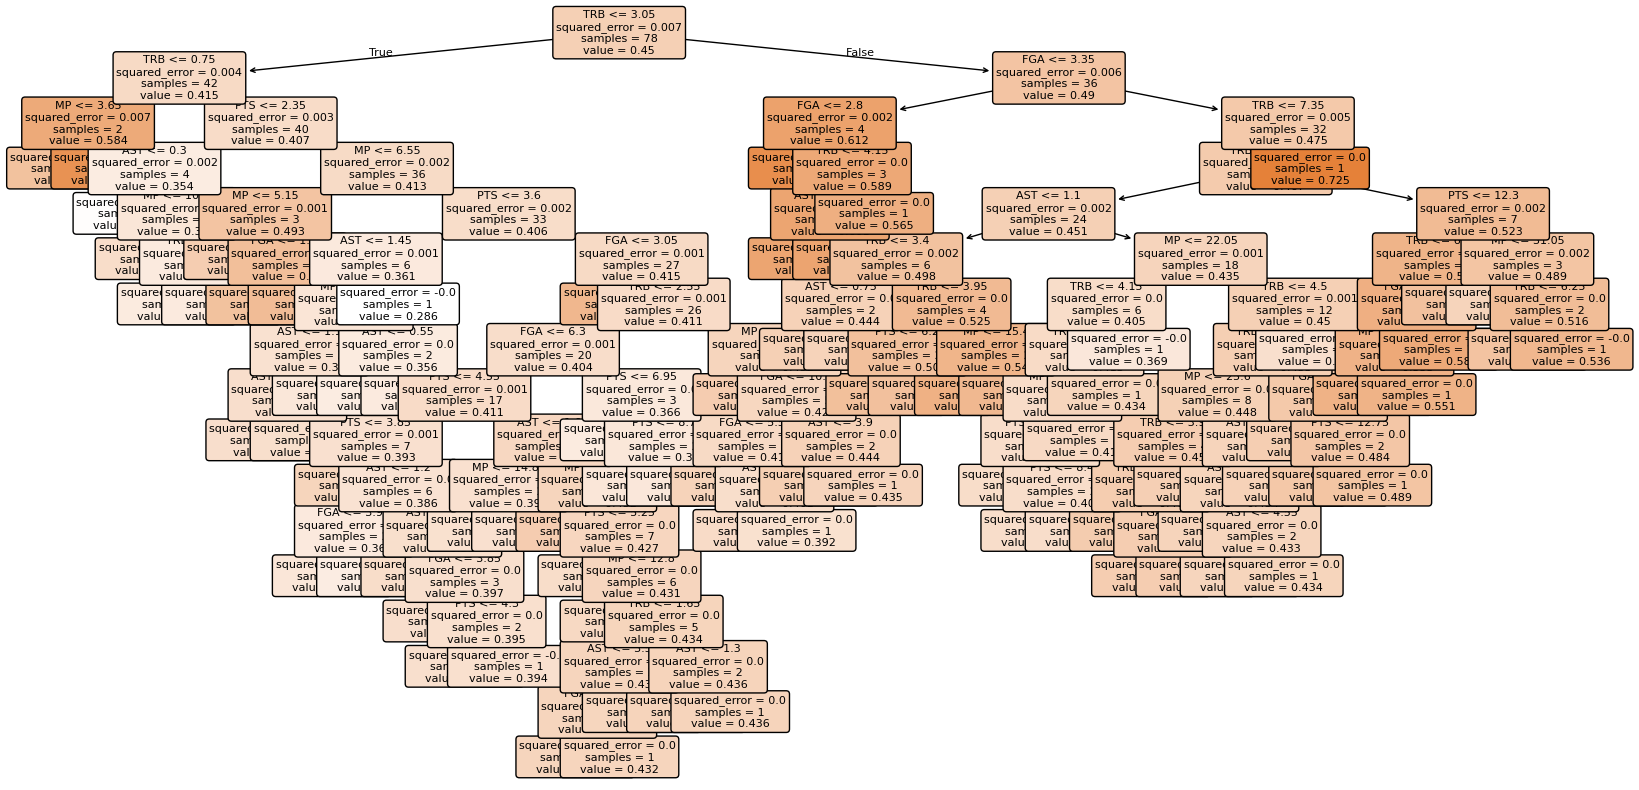

In [38]:
# Convert Spark DataFrame to Pandas DataFrame for sklearn
pandas_df = df_assembled.toPandas()

# Prepare data for sklearn
X = pandas_df[features]
y = pandas_df["FG%"]

# Create and train a decision tree model (for visualization)
decision_tree = tree.DecisionTreeRegressor()
decision_tree.fit(X, y)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
tree.plot_tree(decision_tree, feature_names=features, filled=True, rounded=True, fontsize=8)
plt.show()


Curry

In [21]:
# Dados fictícios para os próximos 82 jogos (adapte conforme necessário)
future_data = create_spark_session.createDataFrame([(16.7, 22.3, 6.5, 4.8,31.2)], ["FGA", "PTS", "AST", "TRB","MP"])

# Aplicando o assembler nos dados futuros
future_assembled = assembler.transform(future_data)

# Realizando a previsão para os próximos jogos
future_predictions = rf_model.transform(future_assembled)

# Exibindo as previsões de FG% para os próximos jogos
future_predictions.select("prediction").show()

+------------------+
|        prediction|
+------------------+
|0.4598770640960348|
+------------------+



Westbrook

In [22]:
# Dados fictícios para os próximos 82 jogos (adapte conforme necessário)
future_data = create_spark_session.createDataFrame([(9.9, 12, 6.6, 4.7,26.8)], ["FGA", "PTS", "AST", "TRB","MP"])

# Aplicando o assembler nos dados futuros
future_assembled = assembler.transform(future_data)

# Realizando a previsão para os próximos jogos
future_predictions = rf_model.transform(future_assembled)

# Exibindo as previsões de FG% para os próximos jogos
future_predictions.select("prediction").show()

+-------------------+
|         prediction|
+-------------------+
|0.45906873076270144|
+-------------------+



Gabe Vicent

In [23]:
# Dados fictícios para os próximos 82 jogos (adapte conforme necessário)
future_data = create_spark_session.createDataFrame([(4.3, 4.3, 0.9, 1.3,18.9)], ["FGA", "PTS", "AST", "TRB","MP"])

# Aplicando o assembler nos dados futuros
future_assembled = assembler.transform(future_data)

# Realizando a previsão para os próximos jogos
future_predictions = rf_model.transform(future_assembled)

# Exibindo as previsões de FG% para os próximos jogos
future_predictions.select("prediction").show()

+-------------------+
|         prediction|
+-------------------+
|0.43450171289967354|
+-------------------+



Luka Doncic

In [24]:
# Dados fictícios para os próximos 82 jogos (adapte conforme necessário)
future_data = create_spark_session.createDataFrame([(21.2,28.1,7.8,8.3,35.7)], ["FGA", "PTS", "AST", "TRB","MP"])

# Aplicando o assembler nos dados futuros
future_assembled = assembler.transform(future_data)

# Realizando a previsão para os próximos jogos
future_predictions = rf_model.transform(future_assembled)

# Exibindo as previsões de FG% para os próximos jogos
future_predictions.select("prediction").show()

+-------------------+
|         prediction|
+-------------------+
|0.47804820045967106|
+-------------------+



JOKIC

In [25]:
# Dados fictícios para os próximos 82 jogos (adapte conforme necessário)
future_data = create_spark_session.createDataFrame([(21.7,31.5,9.7,13,37.1)], ["FGA", "PTS", "AST", "TRB","MP"])

# Aplicando o assembler nos dados futuros
future_assembled = assembler.transform(future_data)

# Realizando a previsão para os próximos jogos
future_predictions = rf_model.transform(future_assembled)

# Exibindo as previsões de FG% para os próximos jogos
future_predictions.select("prediction").show()

+-------------------+
|         prediction|
+-------------------+
|0.47804820045967106|
+-------------------+



Jaylen Brown

In [26]:
# Dados fictícios para os próximos 82 jogos (adapte conforme necessário)
future_data = create_spark_session.createDataFrame([(13,12,3,9,25)], ["FGA", "PTS", "AST", "TRB","MP"])

# Aplicando o assembler nos dados futuros
future_assembled = assembler.transform(future_data)

# Realizando a previsão para os próximos jogos
future_predictions = rf_model.transform(future_assembled)

# Exibindo as previsões de FG% para os próximos jogos
future_predictions.select("prediction").show()

+-------------------+
|         prediction|
+-------------------+
|0.47578986712633775|
+-------------------+

